In [6]:
#!pip install numpy
#!pip install prettytable
#!pip install scikit-learn

In [7]:
import random
from abc import ABC, abstractmethod

import numpy as np

from sklearn.datasets import fetch_openml
import os

import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
class Activation:
    @staticmethod
    def SIGMOID():
        def activation(x):
            return 1 / (1 + np.exp(-x))
        def derivative(x):
            return x * (1 - x)
        return activation, derivative
    
    @staticmethod
    def TANH():
        def activation(x):
            return np.tanh(x)
        def derivative(x):
            return 1 - x ** 2
        return activation, derivative


In [9]:
class Layer:
    def __init__(self, input_size, output_size, activation_func):
        self.activate, self.derivative = activation_func()
        self.weights = np.random.uniform(-0.5,0.5,size=(input_size, output_size))
        self.biases = np.zeros(output_size)        
    def __call__(self):
        return {
            'weights':self.weights, 
            'biases':self.biases
                }

In [10]:
class NN(ABC):
    def __init__(self, layers):
        self.layers = layers
        self.params = self.__params()
    
    def __params(self):
        params = {}
        for i, layer in enumerate(layers):
            params[f'layer{i}'] = {"weights":layer.weights,
                                   "biases":layer.biases}
        return params
    def _forward(self, x):
        for layer in self.layers:
            z = np.dot(x, layer.weights) + layer.biases
            x = layer.activate(z)
            layer.output = np.array([x])
        return x
    
    def _backward(self, x, y, lr):
        error = -(y - self.layers[-1].output)
        for layer in reversed(self.layers):
            delta = error * layer.derivative(layer.output)
            prev_output = np.array([x]) if layer == self.layers[0] else self.layers[self.layers.index(layer) - 1].output
            
            layer.weights -= lr * np.dot(prev_output.T, delta)
            layer.biases -= lr * np.sum(delta, axis=0)
            error = np.dot(delta, layer.weights.T)
        
    @abstractmethod
    def train(self):
        pass
    
    
    
    def __call__(self, input_data):
        output = []
        for i in range(input_data.shape[0]):
            output.append(1 if self._forward(input_data[i]) >= 0.5 else 0)
        return  output
    

In [11]:
class MnistNN(NN):
    def __init__(self, layers):
        super().__init__(layers)
        
    def __MSE(self, output, p_out, error, acc):
        error += np.sum((output - p_out)**2) #MSE
        acc += 0 if(((output < 0.5) and (p_out >= 0.5)) or ((output >= 0.5) and (p_out < 0.5))) else 1
        return error, acc
    
    def train(self, images, labels, epochs, learning_rate=0.01):
        
        index_list = list(range(40000))
        for i in range(epochs):
            random.shuffle(index_list)
            e_loss, e_acc, test_loss, test_acc = 0.0, 0, 0.0, 0
            
            for j in index_list: 
                
                p_out = self._forward(images[j])
                e_loss, e_acc = self.__MSE(labels[j],p_out, e_loss, e_acc)
                self._backward(images[j], labels[j], learning_rate)
            
            for image, label in zip(images[40000:60000], labels[40000:60000]):
                p_out = self._forward(image)
                test_loss, test_acc = self.__MSE(label, p_out, test_loss, test_acc)
                
            print(f"Epoch {i+1}/{epochs}\n"
                  f"Loss: {round(e_loss/40000.0 * 100, 3)}%, Acc: {round(e_acc/40000.0 * 100, 3)}\n"
                  f"Test_loss: {round(test_loss/20000.0 * 100, 3)}%, Test_acc: {round(test_acc/20000.0 * 100, 3)}\n")


In [12]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False) 
mnist.keys() 
mnist["target"]

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [13]:
train_images = mnist["data"].astype('float32') / 255
train_labels  = mnist["target"].reshape(-1, 1).astype('int32')

In [14]:
LEARNING_RATE = 0.1
EPOCH = 20

In [15]:
train_labels.eye(10)

AttributeError: 'numpy.ndarray' object has no attribute 'eye'

In [11]:
#~~Структура нейросети~~#
layers = (
    Layer(784, 64, Activation.TANH),
    Layer(64,32,Activation.TANH),
    Layer(32, 1, Activation.SIGMOID),
)

In [12]:
model = MnistNN(layers) #создание объекта нейросети
print(model.params['layer0']['weights']) #вывод параметров

[[ 0.13169108  0.2273986   0.13490055 ...  0.46924374 -0.07378422
   0.01482344]
 [ 0.39166483  0.29408181  0.00325365 ... -0.1597902  -0.10812231
  -0.17585358]
 [-0.44801157  0.48494881  0.15743215 ... -0.48225876 -0.15203902
  -0.20978564]
 ...
 [-0.4596138  -0.4681328   0.28642268 ... -0.04090287  0.16585185
   0.35983006]
 [-0.03192503 -0.0096645   0.06174865 ...  0.14054783  0.35553494
  -0.34532113]
 [ 0.41982925  0.17735265 -0.05293718 ...  0.07680627  0.48593669
  -0.31916659]]


In [13]:
#~~Обучение нейросети~~#
model.train(train_images,train_labels, EPOCH, learning_rate=LEARNING_RATE) 

Epoch 1/20
Loss: 2.811%, Acc: 96.555
Test_loss: 1.65%, Test_acc: 97.955

Epoch 2/20
Loss: 1.344%, Acc: 98.29
Test_loss: 1.574%, Test_acc: 98.08

Epoch 3/20
Loss: 1.028%, Acc: 98.703
Test_loss: 1.294%, Test_acc: 98.48

Epoch 4/20
Loss: 0.854%, Acc: 98.977
Test_loss: 1.205%, Test_acc: 98.57

Epoch 5/20
Loss: 0.669%, Acc: 99.168
Test_loss: 1.173%, Test_acc: 98.56

Epoch 6/20
Loss: 0.601%, Acc: 99.25
Test_loss: 1.595%, Test_acc: 98.1

Epoch 7/20
Loss: 0.515%, Acc: 99.362
Test_loss: 1.178%, Test_acc: 98.595

Epoch 8/20
Loss: 0.43%, Acc: 99.492
Test_loss: 0.95%, Test_acc: 98.825

Epoch 9/20
Loss: 0.421%, Acc: 99.502
Test_loss: 1.144%, Test_acc: 98.52

Epoch 10/20
Loss: 0.38%, Acc: 99.54
Test_loss: 0.909%, Test_acc: 98.88

Epoch 11/20
Loss: 0.331%, Acc: 99.61
Test_loss: 0.992%, Test_acc: 98.76

Epoch 12/20
Loss: 0.286%, Acc: 99.682
Test_loss: 0.881%, Test_acc: 98.915

Epoch 13/20
Loss: 0.22%, Acc: 99.75
Test_loss: 0.938%, Test_acc: 98.86

Epoch 14/20
Loss: 0.263%, Acc: 99.697
Test_loss: 0.982

In [24]:
print(model.params)

{'layer0': {'weights': array([[ 0.13169108,  0.2273986 ,  0.13490055, ...,  0.46924374,
        -0.07378422,  0.01482344],
       [ 0.39166483,  0.29408181,  0.00325365, ..., -0.1597902 ,
        -0.10812231, -0.17585358],
       [-0.44801157,  0.48494881,  0.15743215, ..., -0.48225876,
        -0.15203902, -0.20978564],
       ...,
       [-0.4596138 , -0.4681328 ,  0.28642268, ..., -0.04090287,
         0.16585185,  0.35983006],
       [-0.03192503, -0.0096645 ,  0.06174865, ...,  0.14054783,
         0.35553494, -0.34532113],
       [ 0.41982925,  0.17735265, -0.05293718, ...,  0.07680627,
         0.48593669, -0.31916659]]), 'biases': array([-0.1350816 , -0.02624007,  0.00178781,  0.21989743, -0.03239686,
       -0.17092658, -0.13486873,  0.05963646,  0.12937516,  0.01914248,
       -0.11328176, -0.10369744, -0.09078911, -0.15464301, -0.10728414,
       -0.02658643,  0.09515547,  0.17829258,  0.02915315, -0.19014364,
       -0.09990193, -0.13552919,  0.0066716 , -0.04310688,  0.020

In [14]:
def RGB2URGB(img):
    gray = lambda rgb: np.dot(rgb[..., :3], [0.299, 0.587, 0.114])
    return 1-gray(img).astype("float32") / 255

In [15]:
PATH = "C:/Users/madro/Documents/GitHub/Khokhlov_Dimitrii_20121_23/AI/P.5/data/test/"

In [16]:
def show(images, labels):
    for img, label in zip(images, labels):
        plt.imshow(np.array([img]).reshape(28,28), cmap = 'grey')
        predict = model(np.array([img]))[0]
        color = "red" if predict != label[0]  else "blue"
        plt.title(f"Real:{label[0]} Predicted:{predict}", color=color)
        plt.show()

In [19]:
train_labels

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

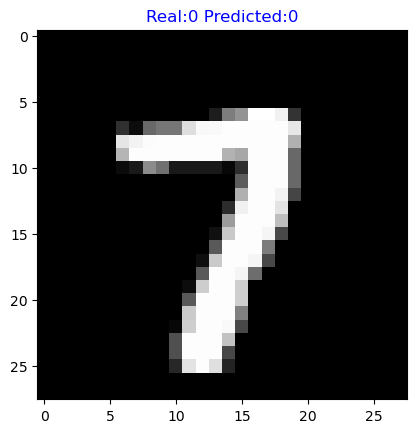

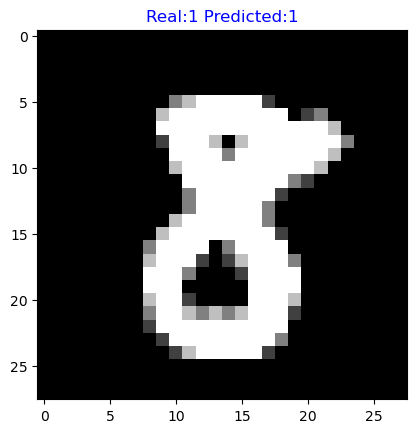

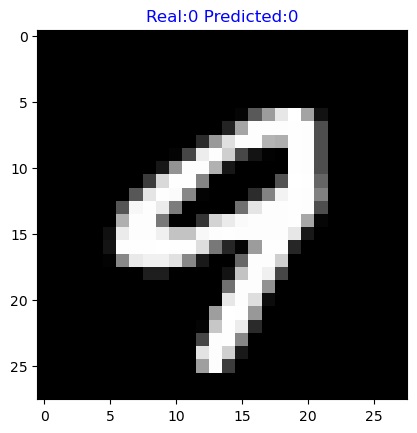

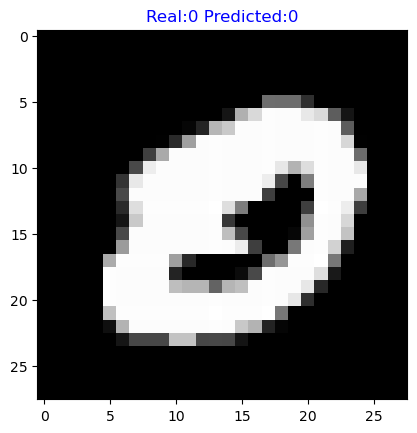

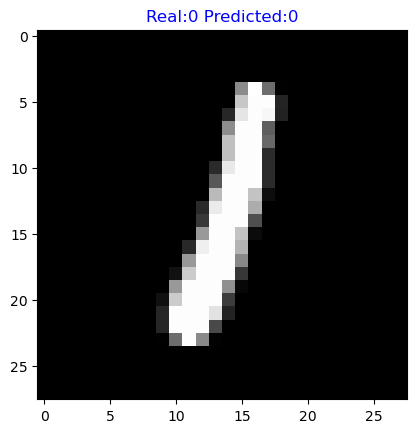

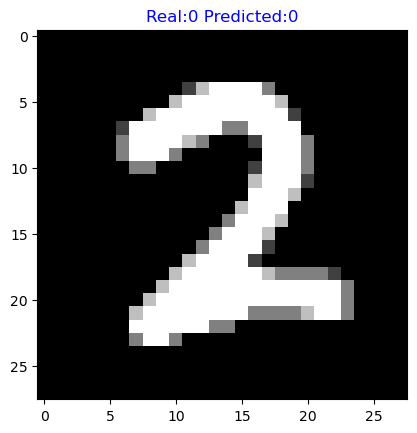

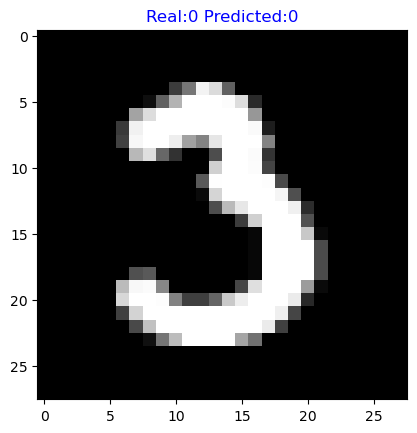

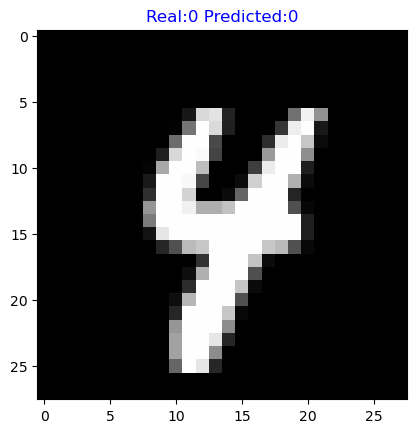

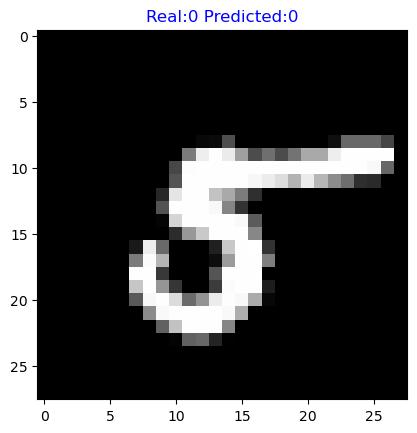

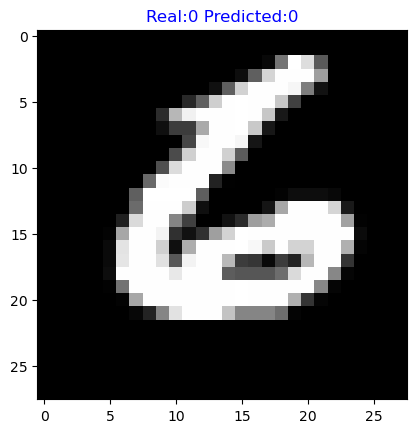

In [27]:
test_img =  train_images[-10:]
test_labels = train_labels[-10:]
show(test_img, test_labels)

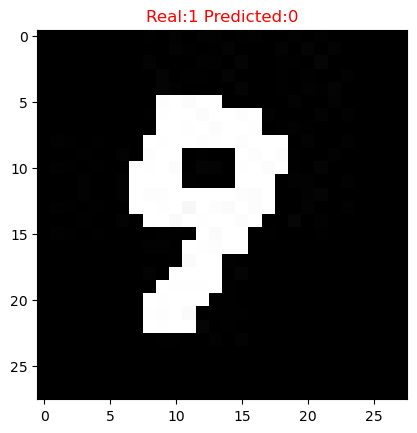

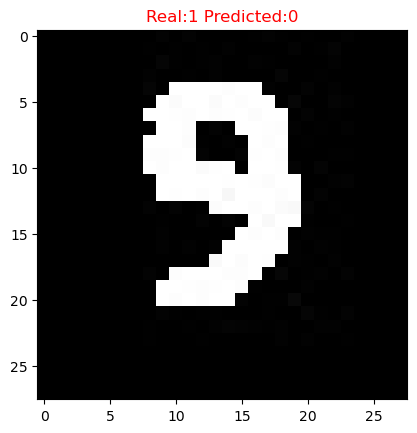

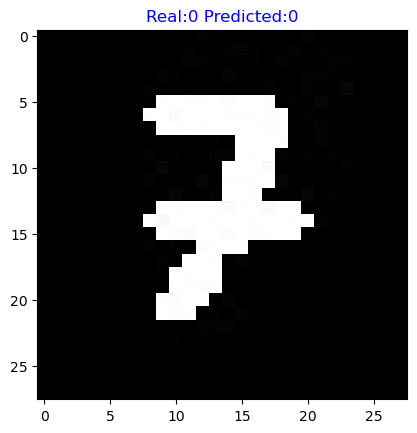

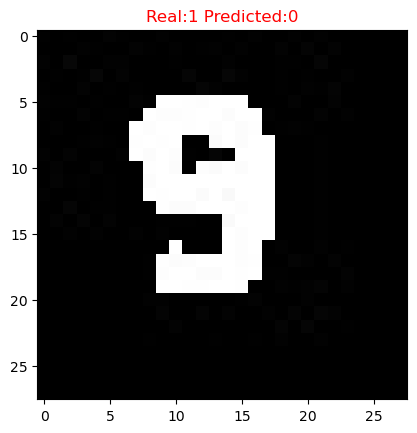

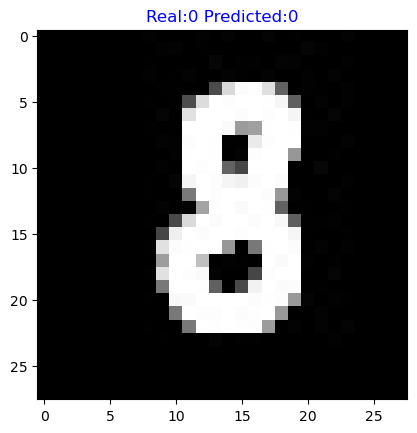

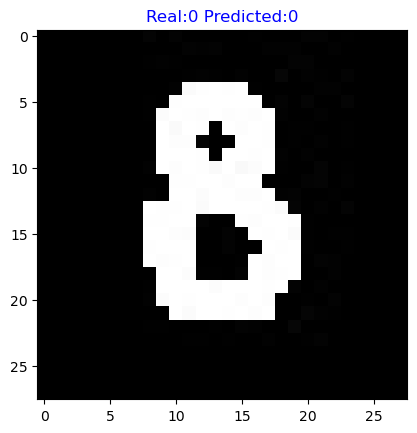

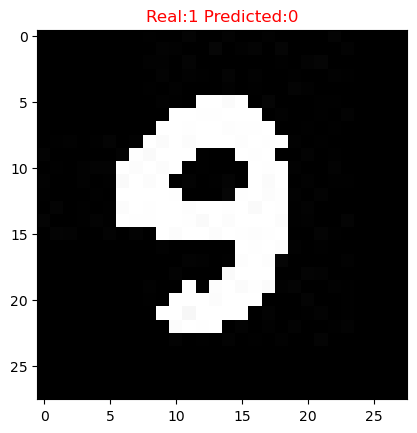

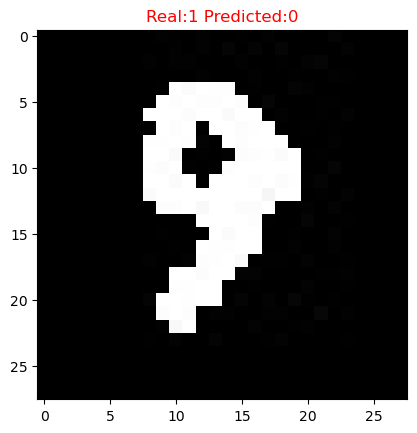

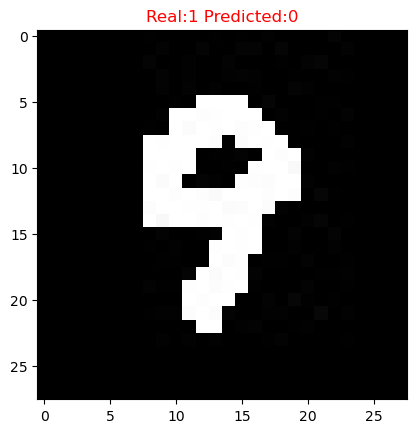

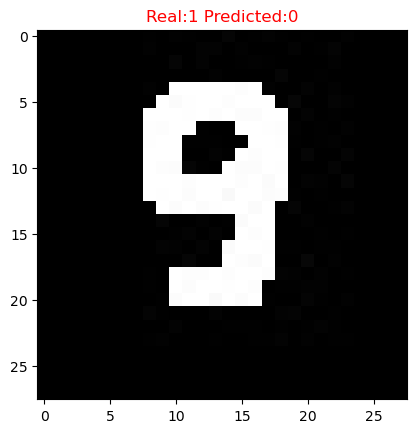

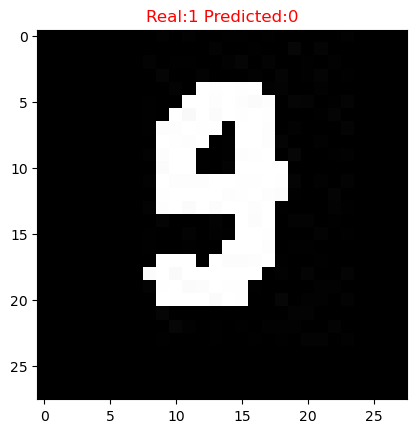

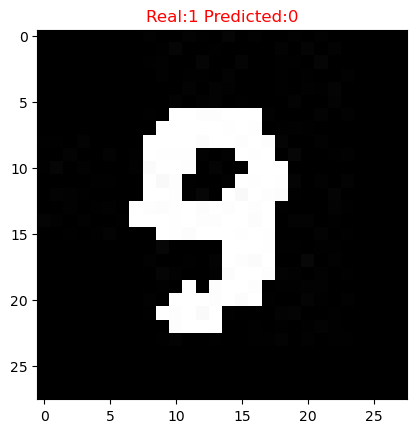

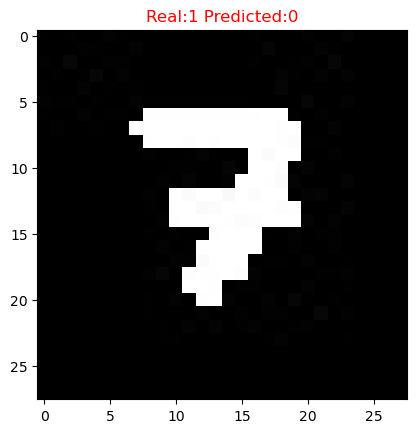

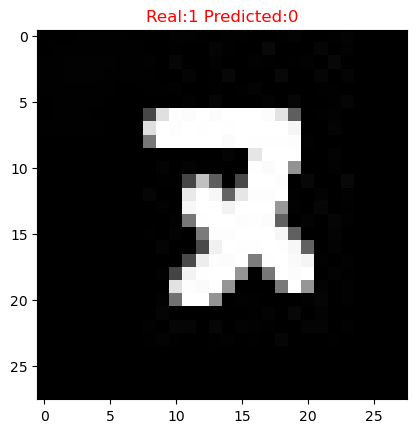

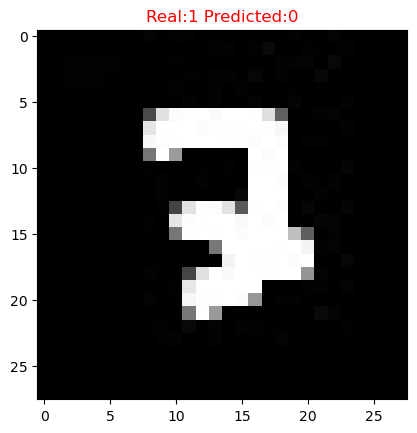

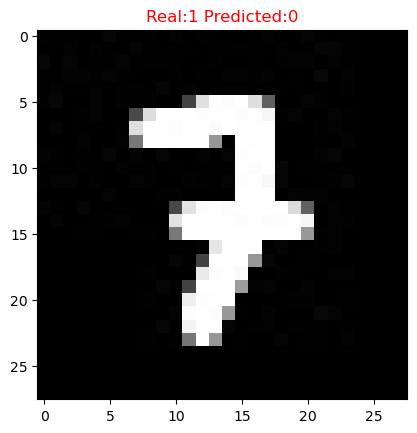

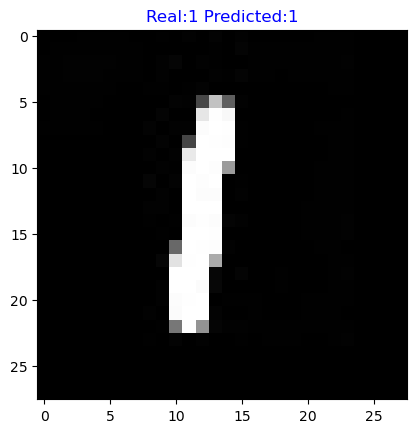

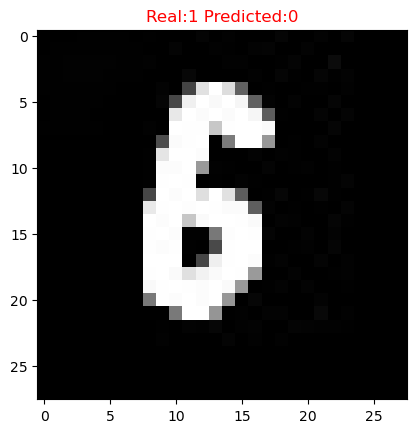

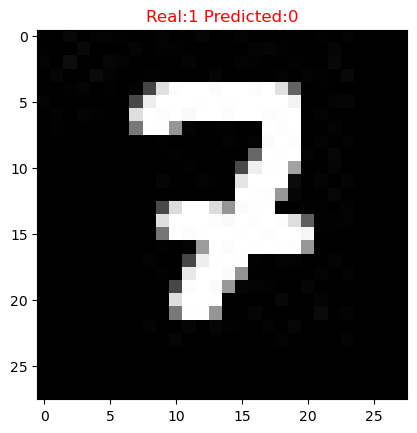

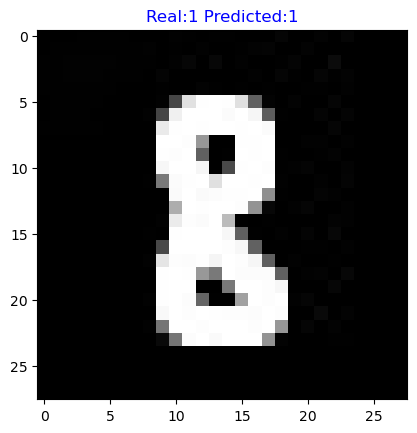

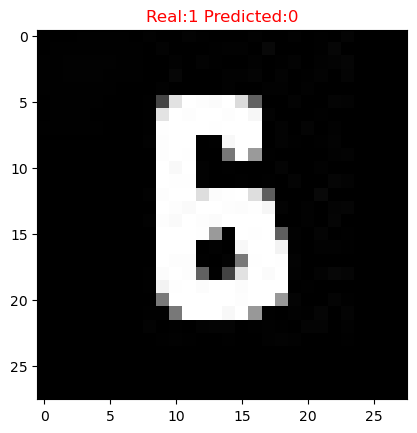

In [17]:
images=[]
for i in range(1, len(os.listdir(PATH)) + 1):
    img = plt.imread(f"{PATH}test{i}.jpg",format = "jpeg")
    images.append(RGB2URGB(img).reshape(784))
labels = np.array([1,1,0,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]).reshape(-1,1)
show(images, labels)